In [1]:
import pandas as pd

In [5]:
data = pd.read_csv("tx.csv")
data.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [4]:
category_counts = data.groupby('category').size()

print(category_counts)

category
'es_barsandrestaurants'      6373
'es_contents'                 885
'es_fashion'                 6454
'es_food'                   26254
'es_health'                 16133
'es_home'                    1986
'es_hotelservices'           1744
'es_hyper'                   6098
'es_leisure'                  499
'es_otherservices'            912
'es_sportsandtoys'           4002
'es_tech'                    2370
'es_transportation'        505119
'es_travel'                   728
'es_wellnessandbeauty'      15086
dtype: int64


In [6]:
from sympy import symbols, integrate, Heaviside

# Определяем символы
S1, K, a, b = symbols('S1 K a b')

# Функция выплаты по опциону
F = (S1 - K) * Heaviside(S1 - K)

# Функция плотности вероятности для равномерного распределения
f_S1 = 1 / (b - a)

# Вычисляем математическое ожидание
I_F = integrate(F * f_S1, (S1, K, b))

I_F

Piecewise((Integral(Piecewise((0, Abs(S1/K) < 1), (K**2*(meijerg(((2, 1), ()), ((), (1, 0)), S1/K) + 2*meijerg(((3, 1), ()), ((), (1, 0)), S1/K))/(S1*(-a + b)), True)), (S1, K, b)), (K > 0) & (K < oo)), (-Integral(0, K)/(-a + b) + Integral((-K + b)*Heaviside(-K + b), b)/(-a + b), True))

In [11]:
# Изменим подход к расчету, используя дерево биномиальной модели

import numpy as np

# Параметры заданы в запросе
N = 3  # Количество шагов
S0 = 1  # Начальная цена актива
u = 2  # Восходящий множитель
d = 1/2  # Нисходящий множитель
r = 1/2  # Безрисковая процентная ставка
K = 1.5  # Страйк цена

# Функция для расчета цены опциона и стратегии хеджирования
def binomial_option_pricing(N, S0, u, d, r, K):
    # Шаг 1: Генерация цен актива на истечение срока
    asset_prices = np.array([S0 * u**j * d**(N - j) for j in range(N + 1)])
    
    # Шаг 2: Расчет выплаты опциона на истечение срока
    option_payoffs = np.maximum(asset_prices - K, 0)
    
    # Шаг 3: Расчет справедливой цены опциона путем дисконтирования ожидаемых выплат
    # Дисконтирование выплат назад во времени
    q = (1 + r - d) / (u - d)  # Вероятность подъема
    for i in range(N, 0, -1):
        option_payoffs = (q * option_payoffs[:i] + (1 - q) * option_payoffs[1:]) / (1 + r)
    
    # Цена опциона на текущий момент
    option_price = option_payoffs[0]
    
    # Шаг 4: Расчет стратегии хеджирования (дельта-хеджирование)
    # Дельта - это изменение цены опциона относительно изменения цены актива
    delta = (option_payoffs[0] - option_payoffs[1]) / (asset_prices[0] - asset_prices[1])
    
    return option_price, delta


# Создадим дерево цен актива
price_tree = np.zeros((N+1, N+1))
for i in range(N+1):
    for j in range(i+1):
        price_tree[j, i] = S0 * (u ** j) * (d ** (i - j))

# Создадим дерево выплат опциона
payoff_tree = np.maximum(price_tree - K, 0)

# Расчет справедливой цены опциона
for i in range(N-1, -1, -1):
    for j in range(i+1):
        payoff_tree[j, i] = (payoff_tree[j, i+1] * (1 - (1 + r - d) / (u - d)) + 
                             payoff_tree[j+1, i+1] * ((1 + r - d) / (u - d))) / (1 + r)

# Справедливая цена опциона - это значение в корне дерева
option_price = payoff_tree[0, 0]

# Расчет дельты - отношение изменения цены опциона к изменению цены актива на первом шаге
delta = (payoff_tree[0, 1] - payoff_tree[1, 1]) / (price_tree[0, 1] - price_tree[1, 1])

option_price, delta, price_tree, payoff_tree


(0.6364883401920438,
 0.8559670781893004,
 array([[1.   , 0.5  , 0.25 , 0.125],
        [0.   , 2.   , 1.   , 0.5  ],
        [0.   , 0.   , 4.   , 2.   ],
        [0.   , 0.   , 0.   , 8.   ]]),
 array([[0.63648834, 0.09876543, 0.        , 0.        ],
        [0.        , 1.38271605, 0.22222222, 0.        ],
        [0.        , 0.        , 3.        , 0.5       ],
        [0.        , 0.        , 0.        , 6.5       ]]))

In [56]:
import numpy as np
import pandas as pd

# Создадим DataFrame с правдоподобными данными о трех облигациях
np.random.seed(0)  # Для воспроизводимости данных

# Параметры облигаций
bonds_info = {
    'Bond': ['Bond A', 'Bond B', 'Bond C'],
    'Price': [970, 950, 840],  # Цена облигаций
    'Nominal': [1000, 1000, 1000],  # Номинал
    'Coupon Rate (%)': [10, 11, 9],  # Купонная ставка в %
    'Years to Maturity': [1, 2, 3],  # Срок до погашения в годах
    'Coupons per Year': [2, 2, 2],  # Частота выплаты купонов в год
}

bonds_df = pd.DataFrame(bonds_info)

bonds_df['Coupon Payment'] = bonds_df['Nominal'] * (bonds_df['Coupon Rate (%)'] / 100) / bonds_df['Coupons per Year']

bonds_df


,Bond,Price,Nominal,Coupon Rate (%),Years to Maturity,Coupons per Year,Coupon Payment
0,Bond A,970,1000,10,1,2,50.0
1,Bond B,950,1000,11,2,2,55.0
2,Bond C,840,1000,9,3,2,45.0


In [57]:
def bootstrap_piecewise_constant(bonds_df):
    # Сортируем облигации по сроку погашения
    bonds_df = bonds_df.sort_values(by='Years to Maturity')
    # Инициализируем словарь для спотовых ставок
    spot_rates = {}

    # Перебираем каждую облигацию для решения кусочно-постоянных ставок
    for index, bond in bonds_df.iterrows():
        # Количество полугодов до погашения
        periods = int(bond['Years to Maturity'] * bond['Coupons per Year'])
        # Сумма дисконтированных купонов на данный момент
        discounted_coupons_sum = 0
        # Рассчитываем дисконтированную стоимость купонов на основе уже найденных спотовых ставок
        for period in range(1, periods):
            if period in spot_rates:
                discounted_coupons_sum += bond['Coupon Payment'] / ((1 + spot_rates[period]) ** period)
        
        # Решаем уравнение для нахождения спотовой ставки текущего периода
        remaining_cash_flow = bond['Price'] - discounted_coupons_sum
        spot_rate = ((bond['Coupon Payment'] + bond['Nominal']) / remaining_cash_flow) ** (1/periods) - 1
        # Сохраняем спотовую ставку для текущего периода
        spot_rates[periods] = spot_rate

    return spot_rates

# Вызываем функцию бутстраппинга для решения кусочно-постоянных ставок
spot_rates = bootstrap_piecewise_constant(bonds_df)
spot_rates

{2: 0.04042021645300786, 4: 0.040759036319938824, 6: 0.05449216447895022}

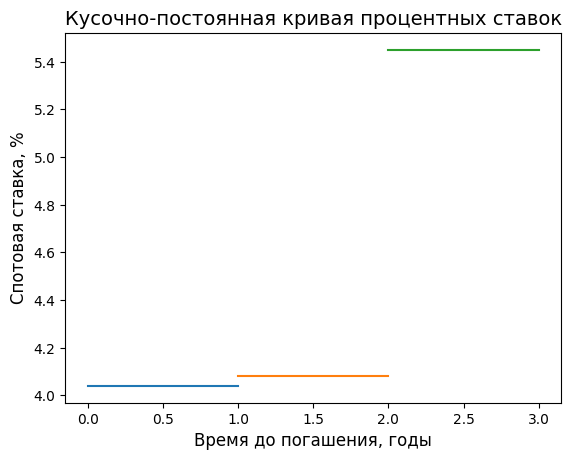

In [67]:
plt.plot([0, 1], [round(spot_rates[2] * 100, 2), round(spot_rates[2] * 100, 2)])
plt.plot([1, 2], [round(spot_rates[4] * 100, 2), round(spot_rates[4] * 100, 2)])
plt.plot([2, 3], [round(spot_rates[6] * 100, 2), round(spot_rates[6] * 100, 2)])
plt.title('Кусочно-постоянная кривая процентных ставок', fontsize=14)
plt.xlabel('Время до погашения, годы', fontsize=12)
plt.ylabel('Спотовая ставка, %', fontsize=12)
plt.show()

In [70]:
from scipy.optimize import minimize
import numpy as np

# Имеющиеся данные: времена до погашения и спотовые ставки
times = np.array([0.5, 1, 1.5, 2, 2.5, 3])

observed_rates = []
for value in spot_rates.values():
    observed_rates.append(value)
    observed_rates.append(value)

observed_rates = np.array(observed_rates)

# Определим функцию для модели Свенсона, используя формулу, указанную в файле пользователя
def svensson_model(t, beta0, beta1, beta2, beta3, tau1, tau2):
    return (beta0 + 
            (beta1 + beta2) * (1 - np.exp(-t / tau1)) / (t / tau1) - 
            beta2 * np.exp(-t / tau1) + 
            beta3 * ((1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2)))

# Функция потерь для калибровки модели Свенсона
def svensson_loss(params, times, observed_rates):
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    return np.sum((observed_rates - svensson_model(times, beta0, beta1, beta2, beta3, tau1, tau2))**2)

# Начальные параметры для калибровки модели Свенсона
initial_params_svensson = [0.03, -0.02, 0.01, 0.01, 1.0, 1.0]

# Калибровка модели Свенсона с помощью оптимизации
result_svensson = minimize(svensson_loss, initial_params_svensson, args=(times, observed_rates),
                           bounds=[(None, None), (None, None), (None, None), (None, None), (0.01, None), (0.01, None)])

# Проверяем, успешно ли прошла оптимизация
if result_svensson.success:
    fitted_params_svensson = result_svensson.x
    print(f"Оптимизированные параметры модели Свенсона: {fitted_params_svensson}")
else:
    raise ValueError(result_svensson.message)


Оптимизированные параметры модели Свенсона: [ 0.10930919 -0.05592682 -0.06712828 -0.06703119  1.0077706   1.00464239]


In [92]:
from scipy.optimize import minimize
import numpy as np


times = np.array([1, 2, 3])

# Функция для расчета теоретической цены облигации по модели Васичека
def vasicek_bond_price(r0, a, b, sigma, t, F, C, times):
    # Расчет интеграла A(t)
    B = (1 - np.exp(-a * times)) / a
    A = np.exp((B - times) * (a**2 * b - 0.5 * sigma**2) / a**2 - (sigma**2 * B**2) / (4 * a))
    
    # Расчет теоретической цены облигации
    return (F * A * np.exp(-B * r0) + C * np.sum(A * np.exp(-B * r0)))[-1]

# Функция потерь для калибровки модели Васичека
def vasicek_loss(params, r0, F, C, times, market_prices):
    a, b, sigma = params
    theoretical_prices = [vasicek_bond_price(r0, a, b, sigma, t, F, C, times[:i+1]) for i, t in enumerate(times)]
    print(market_prices[:len(theoretical_prices)])
    print(theoretical_prices)
    return np.sum((market_prices - theoretical_prices) ** 2)

# Начальные параметры для калибровки модели Васичека
initial_params_vasicek = [0.1, 0.05, 0.01]  # Примерные значения a, b, sigma

# Рыночные цены облигаций (используем цены из предыдущих данных)
market_prices = bonds_df['Price'].values
# Номинал облигации
F = 1000
# Купонный платеж (используем средний купонный платеж из предыдущих данных)
C = bonds_df['Coupon Payment'].mean()

# Калибровка модели Васичека с помощью оптимизации
result_vasicek = minimize(
    vasicek_loss, initial_params_vasicek,
    args=(observed_rates[0], F, C, times, market_prices),
    bounds=[(0, None), (0, None), (0, None)]
)

# Проверяем, успешно ли прошла оптимизация
if result_vasicek.success:
    fitted_params_vasicek = result_vasicek.x
    # Возвращаем оптимизированные параметры и значение функции потерь для оценки качества подгонки
    fitted_loss_vasicek = result_vasicek.fun
    print(fitted_params_vasicek, fitted_loss_vasicek)
else:
    raise ValueError(result_vasicek.message)


[970 950 840]
[1007.953468635745, 1014.8307236303541, 1020.8358123972532]
[970 950 840]
[1007.9534685904513, 1014.830723464289, 1020.8358120522181]
[970 950 840]
[1007.9534681481557, 1014.8307217961848, 1020.8358085047728]
[970 950 840]
[1007.9534686669369, 1014.8307238543547, 1020.8358130794678]
[970 950 840]
[922.3964908020807, 736.1485443196693, 532.881962835162]
[970 950 840]
[922.3964867080248, 736.1485332538441, 532.881947840297]
[970 950 840]
[922.3964899842443, 736.1485419686178, 532.8819594526449]
[970 950 840]
[922.3964908288355, 736.1485444613836, 532.8819631173825]
[970 950 840]
[987.5642104595997, 940.9623731408456, 872.0437656176404]
[970 950 840]
[987.5642089293175, 940.9623679762158, 872.0437560773515]
[970 950 840]
[987.5642098482648, 940.9623709886216, 872.0437614733439]
[970 950 840]
[987.5642104895127, 940.9623733395488, 872.0437661603911]
[970 950 840]
[953.5986276980353, 834.1369132282593, 690.526486925346]
[970 950 840]
[953.5986259095067, 834.1369081752875, 690.

In [93]:
# Constants given in the problem
R = 1000  # Initial Reserve
CF1 = 50000  # Cash Flow
p = 1/50  # Probability of default
t = 1  # Time period is one year

# Сalculating the VaR for 1% and 5% considering the discrete distribution and the actual probability of default
# Since the probability of default is 2%, which is higher than 1%, the VaR at 1% is the full loss (CF1 + R)
# But since the probability of default is less than 5%, the VaR at 5% would be 0 as there is a 95% chance that there will be no default (and hence no loss)

VaR_1_corrected = CF1 + R  # VaR at 1% significance level, which is the loss given default
VaR_5_corrected = 0        # VaR at 5% significance level, since the probability of default is less than 5%

VaR_1_corrected, VaR_5_corrected

(51000, 0)

In [94]:
# ES for 1% can be calculated directly since any loss given the default is above the VaR_1% threshold.
# Since the loss given default is 51,000 and happens with a probability of 2%, the ES at 1% is just the expected loss.
ES_1_corrected = CF1 * p

# For the 5% level, since VaR at 5% is 0, and the only possible loss is CF1 (when default occurs),
# the ES is the same as the expected loss because every loss (default event) exceeds the VaR of 0.
ES_5_corrected = CF1 * p  # This is still the expected loss given default

ES_1_corrected, ES_5_corrected

(1000.0, 1000.0)

In [95]:
# Константы, заданные в задаче
R = 1000 # Начальный резерв
CF1 = 50000 # Денежный поток
p = 1/50 # Вероятность дефолта
t = 1 # Период времени — один год

# Расчет VaR для 1% и 5% с учетом дискретного распределения и фактической вероятности дефолта
# Поскольку вероятность дефолта составляет 2%, что выше 1%, VaR при 1% представляет собой полную потерю (CF1 + R)
# Но поскольку вероятность дефолта меньше 5%, VaR при 5% будет равна 0, поскольку вероятность того, что дефолта не будет (и, следовательно, не будет убытков), составляет 95%.

VaR_1_corrected = CF1 + R # VaR при уровне значимости 1 %, что соответствует убытку по умолчанию.
VaR_5_corrected = 0 # VaR при уровне значимости 5%, так как вероятность дефолта меньше 5%

# ES для 1% можно рассчитать напрямую, поскольку любые потери при значении по умолчанию превышают порог VaR_1%.
# Поскольку потери при дефолте составляют 51 000 и происходят с вероятностью 2%, ES при 1% — это всего лишь ожидаемый убыток.
ES_1_corrected = CF1 * p

# Для уровня 5%, поскольку VaR при 5% равен 0, а единственным возможным убытком является CF1 (при наступлении дефолта),
# ES совпадает с ожидаемым убытком, поскольку каждый убыток (событие по умолчанию) превышает VaR, равный 0.
ES_5_corrected = CF1 * p # Это по-прежнему ожидаемые потери при условии дефолта

VaR_1_corrected, VaR_5_corrected, ES_1_corrected, ES_5_corrected

(51000, 0, 1000.0, 1000.0)

In [133]:
from scipy.stats import binom

n = 1 # Количество контрагентов
CF = 50000 # Обязательство каждого контрагента
p_default = 0.02 # Вероятность дефолта для каждого контрагента
R = 1000 # Общий резерв – это сумма обязательств

# VaR для уровня достоверности 1% — это такая сумма, при которой вероятность убытков, превышающих эту сумму, меньше или равна 1%.
# Здесь мы ищем количество значений по умолчанию, кумулятивная вероятность которых составляет более 99 %.
VaR_1_num_defaults = binom.ppf(0.99, n, p_default)
print(VaR_1_num_defaults)
# VaR — это убыток, соответствующий чуть большему числу дефолтов.
VaR_1_loss = VaR_1_num_defaults * CF

# VaR для уровня достоверности 5 % — это такая сумма, при которой вероятность убытков, превышающих эту сумму, меньше или равна 5 %.
# Здесь мы ищем количество значений по умолчанию, кумулятивная вероятность которых составляет более 95 %.
VaR_5_num_defaults = binom.ppf(0.95, n, p_default)

# VaR — это убыток, соответствующий чуть большему числу дефолтов.
VaR_5_loss = VaR_5_num_defaults * CF

# ES 5%
losses_over_var_1 = range(int(VaR_1_num_defaults + 1), n + 1)
ES_1 = sum([CF * p_default for _ in losses_over_var_1])

# ES 5%
losses_over_var_5 = range(int(VaR_5_num_defaults + 1), n + 1)
ES_5 = sum([CF * p_default for _ in losses_over_var_5])



R, VaR_1_loss, VaR_5_loss, ES_1, ES_5

1.0


(1000, 50000.0, 0.0, 0, 1000.0)

(5000, 1000.0, 1000.0, 7.763184000000003, 7.763184000000003)

In [132]:
from scipy.stats import binom

n = 50 # Количество контрагентов
CF = 1000 # Обязательство каждого контрагента
p_default = 0.01 + 0.01 + 0.01**2 # Вероятность дефолта для каждого контрагента
R = n * CF # Общий резерв – это сумма обязательств

# VaR для уровня достоверности 1% — это такая сумма, при которой вероятность убытков, превышающих эту сумму, меньше или равна 1%.
# Здесь мы ищем количество значений по умолчанию, кумулятивная вероятность которых составляет более 99 %.
VaR_1_num_defaults = binom.ppf(0.99, n, p_default)
print(VaR_1_num_defaults)
# VaR — это убыток, соответствующий чуть большему числу дефолтов.
VaR_1_loss = VaR_1_num_defaults * CF

# VaR для уровня достоверности 5 % — это такая сумма, при которой вероятность убытков, превышающих эту сумму, меньше или равна 5 %.
# Здесь мы ищем количество значений по умолчанию, кумулятивная вероятность которых составляет более 95 %.
VaR_5_num_defaults = binom.ppf(0.95, n, p_default)

# VaR — это убыток, соответствующий чуть большему числу дефолтов.
VaR_5_loss = VaR_5_num_defaults * CF

# ES 5%
losses_over_var_1 = range(int(VaR_1_num_defaults + 1), n + 1)
ES_1 = sum([CF * p_default for _ in losses_over_var_1])

# ES 5%
losses_over_var_5 = range(int(VaR_5_num_defaults + 1), n + 1)
ES_5 = sum([CF * p_default for _ in losses_over_var_5])



R, VaR_1_loss, VaR_5_loss, ES_1, ES_5

4.0


(50000, 4000.0, 3000.0, 924.6000000000007, 944.7000000000007)

In [ ]:
from scipy.stats import norm
import numpy as np

# Заданные параметры
S_0 = 100  # Начальная цена актива
K = 100  # Страйк-цена опциона
r = 0.05  # Безрисковая процентная ставка
sigma = 0.2  # Волатильность актива
T = 1  # Время до исполнения опциона в годах
lambda_drift = 0  # Коэффициент дрейфа, принимаем 0 для упрощения

# Вычисляем d1 и d2
d1 = (np.log(S_0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

# Теперь вычисляем теоретическую стоимость опциона колл по формуле Блэка-Шоулза
call_price = S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Вычисляем вероятность превышения барьера
P_greater_K = 1 - norm.cdf(d2)

# Среднедисконтированная выплата
discounted_payoff = call_price * np.exp(-r * T)

call_price, P_greater_K, discounted_payoff